# SYDE 750: Course Project
## Research Notebook 
Start date: March 19, 2020

Explore learning under conflicting inputs (interfering)

# Implementation

In [2]:
import numpy as np
import nengo
import nengo_spa as spa
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set the default color cycle
# Colors 
cRang = np.linspace(0,1,10)
rgba = [mpl.cm.get_cmap('viridis')(i) for i in cRang]
rgba2 = [mpl.cm.get_cmap('copper')(i) for i in cRang]
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=rgba+rgba2) 

rng = np.random.RandomState(7)

### Generate random unitary vectors


In [3]:
#parameters
dims = 64
n_items = 10
all_pairs = spa.Vocabulary(dimensions=dims, pointer_gen=rng, max_similarity=0.3)

items = np.arange(n_items)+1
list_A = ['A' + str(i) for i in items]
list_B = ['B' + str(i) for i in items]
list_C = ['C' + str(i) for i in items]
list_D = ['D' + str(i) for i in items]

list_AU = [i + '.normalized()' for i in list_A]
list_BU = [i + '.normalized()' for i in list_B]
list_CU = [i + '.normalized()' for i in list_C]
list_DU = [i + '.normalized()' for i in list_D]

#generate pairs
A_B_short = [i[0]+ i[1] for i in list(zip(*[list_A,list_B]))]
C_D_short = [i[0]+ i[1] for i in list(zip(*[list_C,list_D]))]
C_B_short = [i[0]+ i[1] for i in list(zip(*[list_C,list_B]))]
A_D_short = [i[0]+ i[1] for i in list(zip(*[list_A,list_D]))]

A_B = [i[0]+ i[1] + ' = ' + i[0] + '*' + i[1] for i in list(zip(*[list_A,list_B]))]
C_D = [i[0]+ i[1] + ' = ' + i[0] + '*' + i[1] for i in list(zip(*[list_C,list_D]))]
C_B = [i[0]+ i[1] + ' = ' + i[0] + '*' + i[1] for i in list(zip(*[list_C,list_B]))]
A_D = [i[0]+ i[1] + ' = ' + i[0] + '*' + i[1] for i in list(zip(*[list_A,list_D]))]

A_BU = [i + '.normalized()' for i in A_B]
C_DU = [i + '.normalized()' for i in C_D]
C_BU = [i + '.normalized()' for i in C_B]
A_DU = [i + '.normalized()' for i in A_D]


all_pairs.populate(';'.join(list_AU+
                        list_BU+
                        list_CU+
                        list_DU+
                        A_BU+
                        C_DU+
                        C_BU+
                        A_DU))


### Function Definitions

**Cycle through symbols and pairs**

In [4]:
L_phases = lambda t: -(int(t /  (T / 4)) % 2) if t<T else (-1)
R_phases = lambda t: (int(t /  (T / 4)) % 2) if t<T else (1)

def cycle_symsv(vocab,labels,period,dt=0.001):
    
    n = n_items
    
    """Cycles through the symbols"""
    i_every = int(round(period / dt))
    if i_every != period / dt:
        raise ValueError("dt (%s) does not divide period (%s)" % (dt, period))

    def f(t):
        #Which listt
        if (t>=T/2 and t<T): #second list
            j = n
        elif (t>T): #cues 
            j = 2*n 
        else: #first list
            j = 0
        
        i = int(round((t - dt) / dt))  # t starts at dt
        k = j + int(i/i_every) % n
        try:
            return vocab[labels[k]].v
        except: 
            return np.zeros(dims)

    return f

**Test results, accuracy**

In [34]:
def testAcc(probe,vocab,exp_response):
    simT = spa.similarity(sim.data[probe], vocab)
    testList = []
    times = list(
        np.arange(5.4,10,0.5))+list(
        np.arange(15.4,20,0.5))+list(
        np.arange(20.4,25,0.5))
    correct = 0
    almost = 0
    for i in range(0,len(times)):
        top = []
        for j in range(0,3):
            top.append(
                list(vocab.keys())[np.argsort(-simT[int(times[i]*1000):][0], kind='quicksort')[j]])
        testList.append(top)
        if (testList[i][0] == exp_response[i]): correct+=1
        elif (testList[i][1] == exp_response[i]): almost+=1
    return correct,almost,testList

## 1) Control Condition: A-B, C-D

In [9]:
stimuli = all_pairs.create_subset(list_A+list_C)
response =  all_pairs.create_subset(list_B+list_D)
exp_pairs = all_pairs.create_subset(A_B_short+C_D_short)

keynames = list_A+list_C
valnames = list_B+list_D
pairnames = A_B_short+C_D_short
n_keys = len(keynames)
keys = np.zeros([n_keys,dims])

## 2) Condition 2: A-B, A-D

In [26]:
stimuli = all_pairs.create_subset(list_A)
response =  all_pairs.create_subset(list_B+list_D)
exp_pairs = all_pairs.create_subset(A_B_short+A_D_short)

keynames = list_A+list_A
valnames = list_B+list_D
pairnames = A_B_short+A_D_short
n_keys = len(keynames)
keys = np.zeros([n_keys,dims])

## Generate Cues
Cues are shuffled keys from the first list of pairs

In [27]:
#add cues to keynames
cue_order = np.linspace(1,10,10)
np.random.shuffle(cue_order)
cues = [list_A[int(i)-1] for i in cue_order]
c_resp = [list_B[int(i)-1] for i in cue_order]
pair_resp = [A_B_short[int(i)-1] for i in cue_order]
keynames += cues
valnames += c_resp
pairnames += pair_resp

## Run Experiment

In [39]:
dt = 0.001
period = 0.5
T = period * n_keys * 2
n_neuronsIN = 100*n_keys
n_neurons = 400


# makes array of keys from pointers to pre-calculate intercepts
# -> ensures encoders are selective to one input vector 
# as per https://www.nengo.ai/nengo/examples/learning/learn-associations.html
for i in range(0,len(list(stimuli.keys()))):
    keys[i] = stimuli[keynames[i]].v
intercept = (np.dot(keys, keys.T) - np.eye(n_keys)).flatten().max()

model = spa.Network()

with model:
    
    # when learning is -1 (inactive) recall is 1 (active)
    learning = nengo.Node(output=L_phases)
    recall = nengo.Node(output=R_phases)
    
    #inputs
    stim = nengo.Node(cycle_symsv(stimuli,keynames,period,dt))
    r_in = nengo.Node(cycle_symsv(response,valnames,period,dt))
    #ground truth
    new_pair = nengo.Node(cycle_symsv(exp_pairs,pairnames,period,dt))
    
    with nengo.Network() as learning_net:
        #process input 
        map_ens = nengo.Ensemble(
            n_neuronsIN, dims, intercepts=[intercept] * n_neuronsIN)
        
        # Learn the encoders according to voja rule
        voja = nengo.Voja(learning_rate=0.1, post_synapse=None)
    
        map_in = nengo.Connection(
                    stim, map_ens, synapse=0, learning_rule_type=voja)
        
        nengo.Connection(learning, map_in.learning_rule)
        
        map_result = nengo.Ensemble(n_neuronsIN,dims)
        
        err_ens = nengo.Ensemble(n_neuronsIN,dims)


        
        # Learn the bound pairs
        map_out = nengo.Connection(
            map_ens,
            map_result,
            learning_rule_type=nengo.PES(0.08),
            function=lambda x: np.zeros(dims))
        nengo.Connection(
            learning, err_ens.neurons, transform=[[10.0]] * n_neuronsIN, synapse=0)
    
    with nengo.Network() as recall_net:        
        
        # Storage
        # Want the STATE ensemble to store only learned values 
        #  i.e. in the recall phases 
        prod = nengo.networks.Product(n_neurons,dims)
        nengo.Connection(recall,prod.input_a,transform=[[1]]*dims,synapse=0)
        nengo.Connection(map_result,prod.input_b,synapse=0)
        
        state_ens = nengo.Ensemble(n_neuronsIN,dims)
        #memory via feedback connection
        nengo.Connection(state_ens,state_ens, transform=1, synapse=0.02)
        
        state_in=nengo.Connection(prod.output, state_ens,synapse=0)
        
        # Calculate the error and use it to drive the PES rule
        nengo.Connection(new_pair, err_ens, transform=-1, synapse=0)
        nengo.Connection(map_result, err_ens, synapse=0)
        nengo.Connection(state_ens, err_ens, transform=-1, synapse=0)
        nengo.Connection(err_ens, map_out.learning_rule)

        #perform unbinding
        cconv = nengo.networks.CircularConvolution(n_neurons, dims, invert_b = True)
        state_out = nengo.Connection(state_ens,cconv.input_a)
        nengo.Connection(stim,cconv.input_b)
    
    #probes
    model.config[nengo.Probe].synapse = nengo.Lowpass(0.03)
    
    # Setup probes
    p_keys = nengo.Probe(stim)
    p_rin = nengo.Probe(r_in)
    p_out = nengo.Probe(cconv.output)
    p_rout1 = nengo.Probe(state_in)
    p_rout2 = nengo.Probe(state_out)
    p_ground = nengo.Probe(new_pair)
    p_learning = nengo.Probe(learning)
    p_min = nengo.Probe(map_in)
    p_mout = nengo.Probe(map_out)    
    
with nengo.Simulator(model, dt=dt) as sim:
    sim.run(T+5)
t = sim.trange()

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

## Inputs

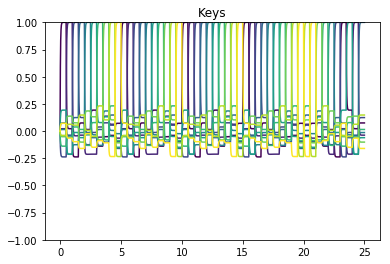

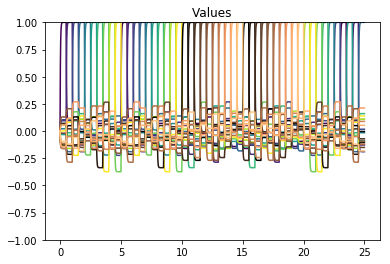

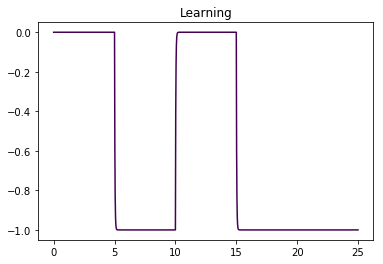

In [29]:
plt.figure()
plt.title("Keys")
plt.plot(sim.trange(), spa.similarity(sim.data[p_keys], stimuli))
plt.ylim(-0.5, 1.1)

plt.figure()
plt.title("Values")
plt.plot(sim.trange(), spa.similarity(sim.data[p_rin], response))
plt.ylim(-0.5, 1.1)

plt.figure()
plt.title("Learning")
plt.plot(sim.trange(), sim.data[p_learning])

## Ground Truth and Result of Learning

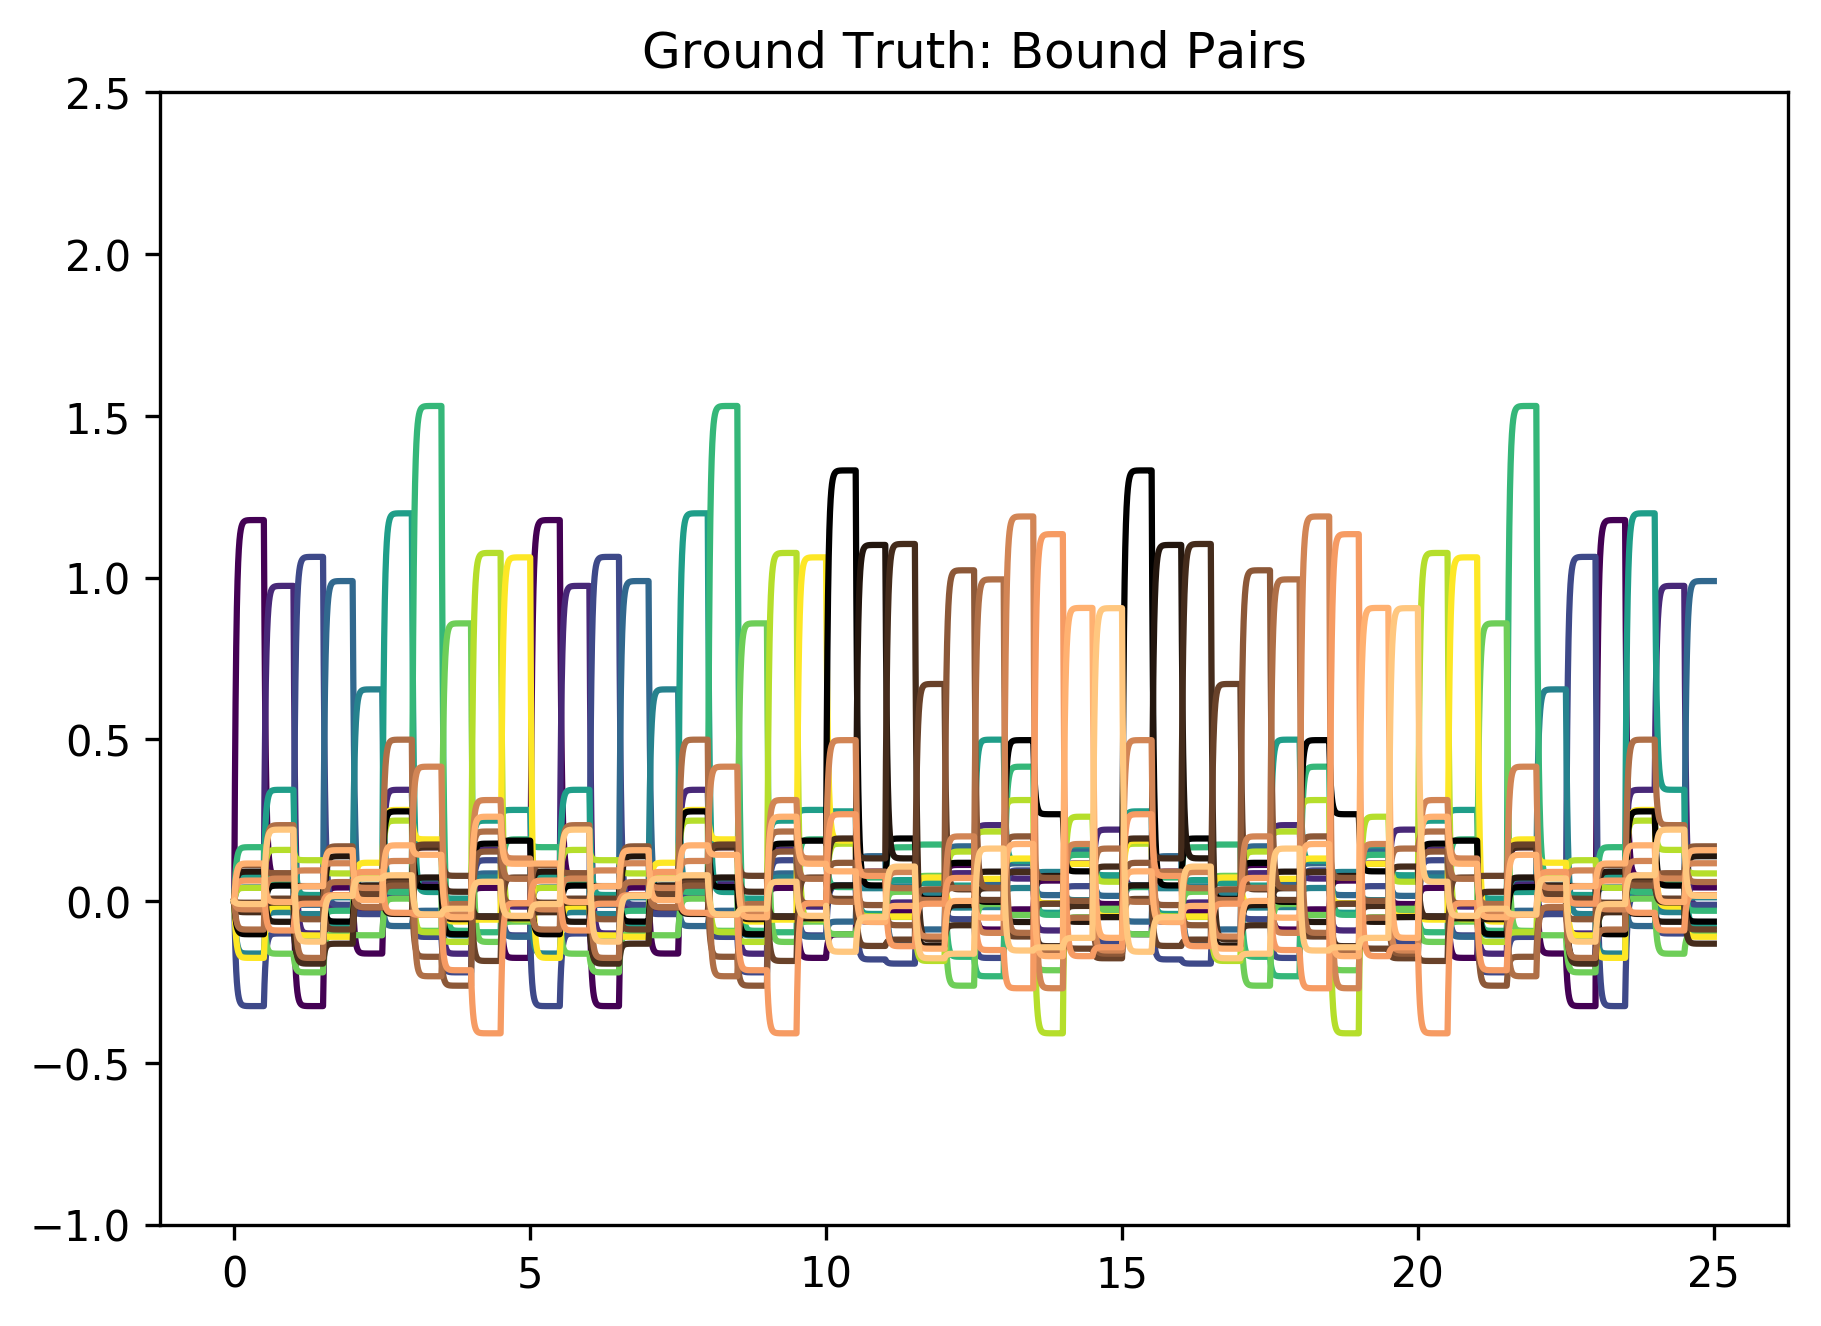

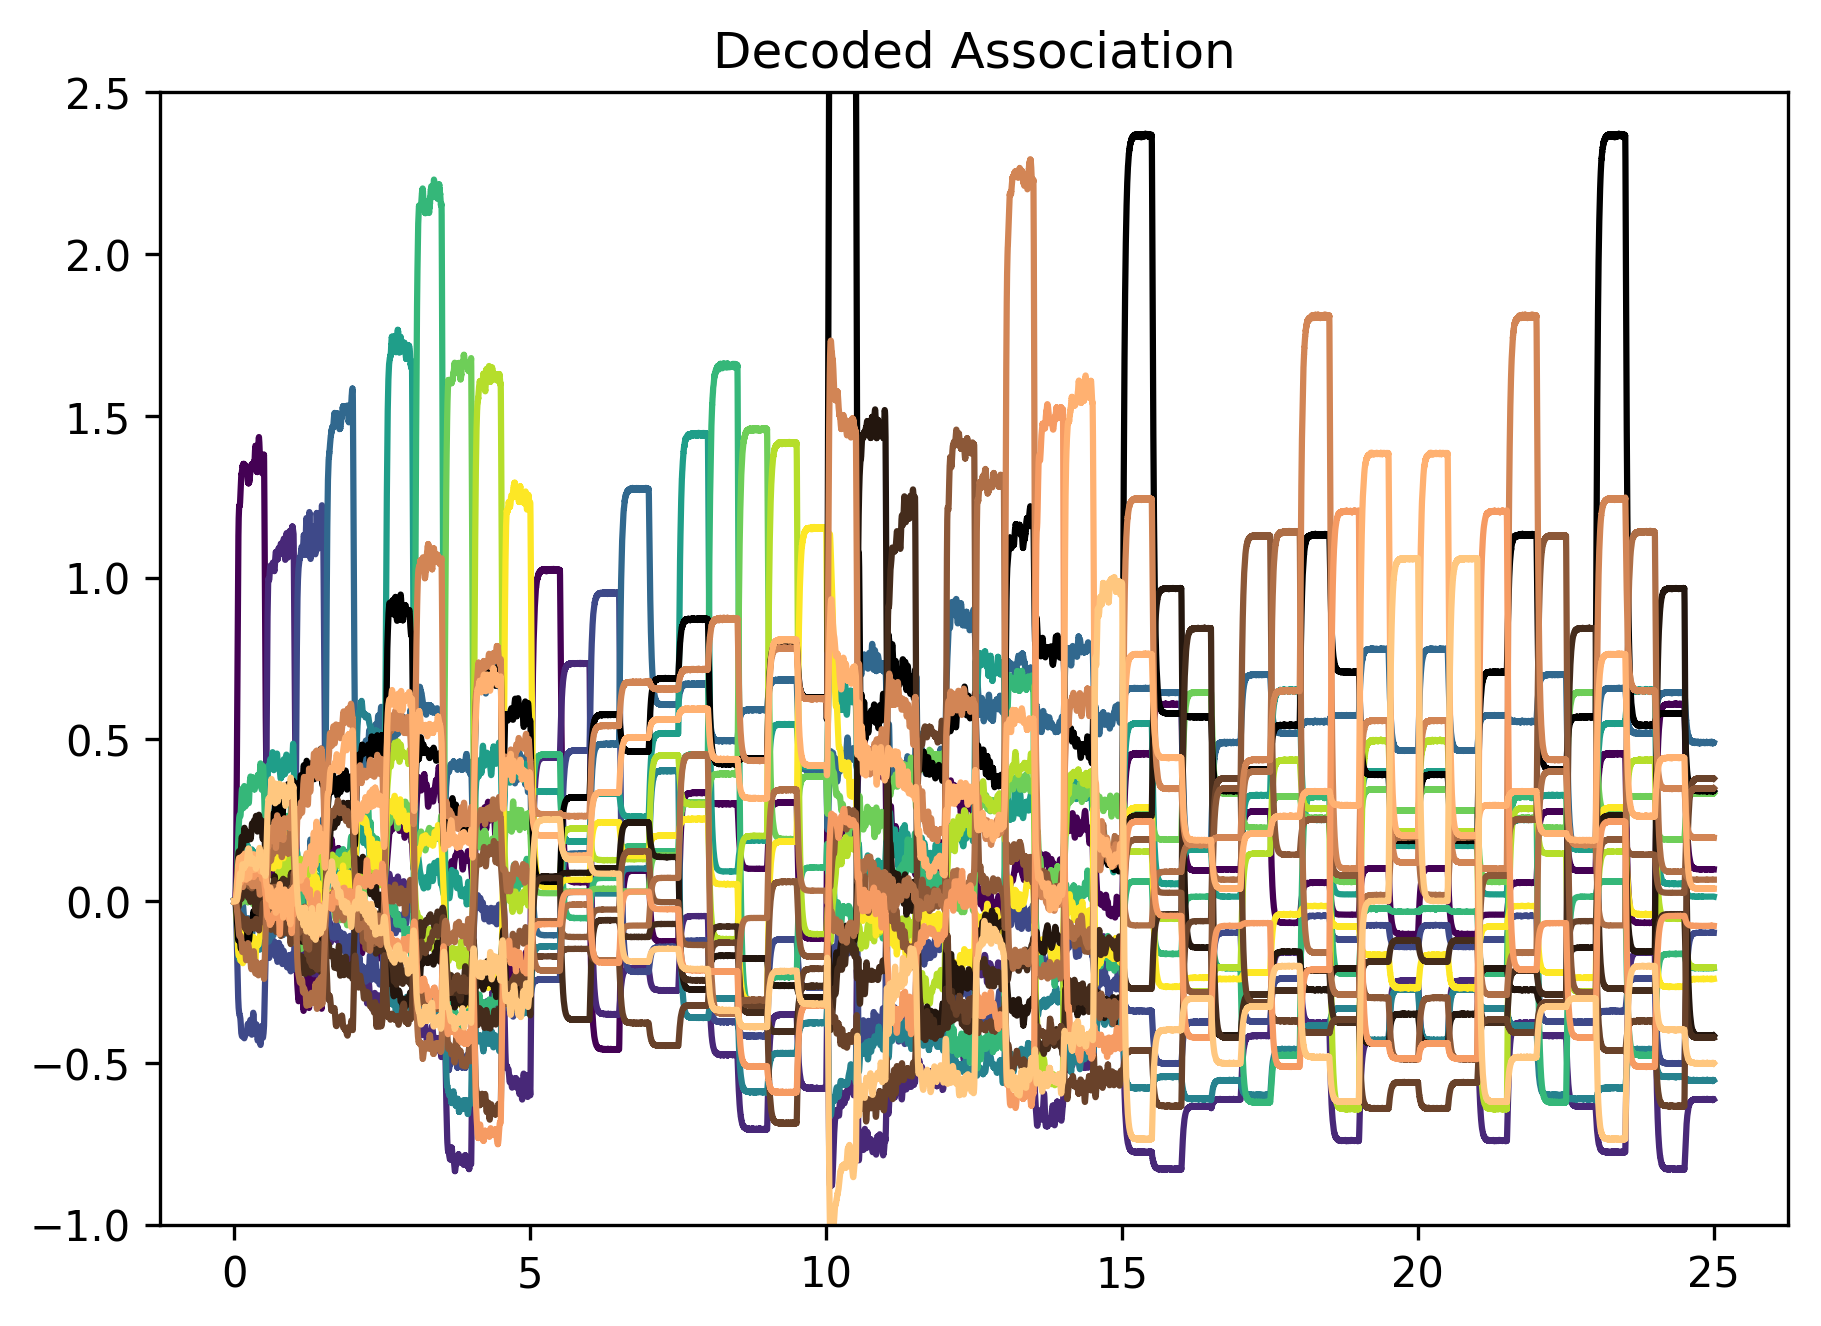

In [40]:
plt.figure(figsize=[7,5],dpi=300)
plt.title("Ground Truth: Bound Pairs")
plt.plot(t, spa.similarity(sim.data[p_ground], exp_pairs))
plt.ylim(-1, 2.5)
plt.savefig('Images/Test4_groundtruth.png')

plt.figure(figsize=[7,5],dpi=300)
plt.title("Decoded Association")
plt.plot(t, spa.similarity(sim.data[p_mout], exp_pairs))
plt.ylim(-1, 2.5)
plt.savefig('Images/Test4_decoded.png')

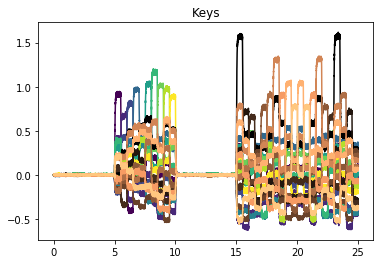

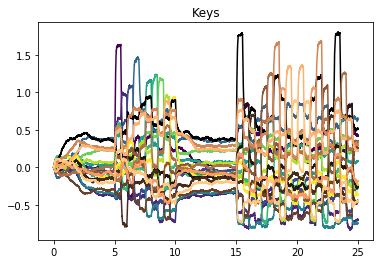

In [41]:
plt.figure()
plt.title("Keys")
plt.plot(t, spa.similarity(sim.data[p_rout1], exp_pairs))
#plt.plot(t, sim.data[p_rout1])
#plt.ylim(-1, 1)

plt.figure()
plt.title("Keys")
plt.plot(t, spa.similarity(sim.data[p_rout2], exp_pairs))
#plt.ylim(-1, 1)
plt.show()

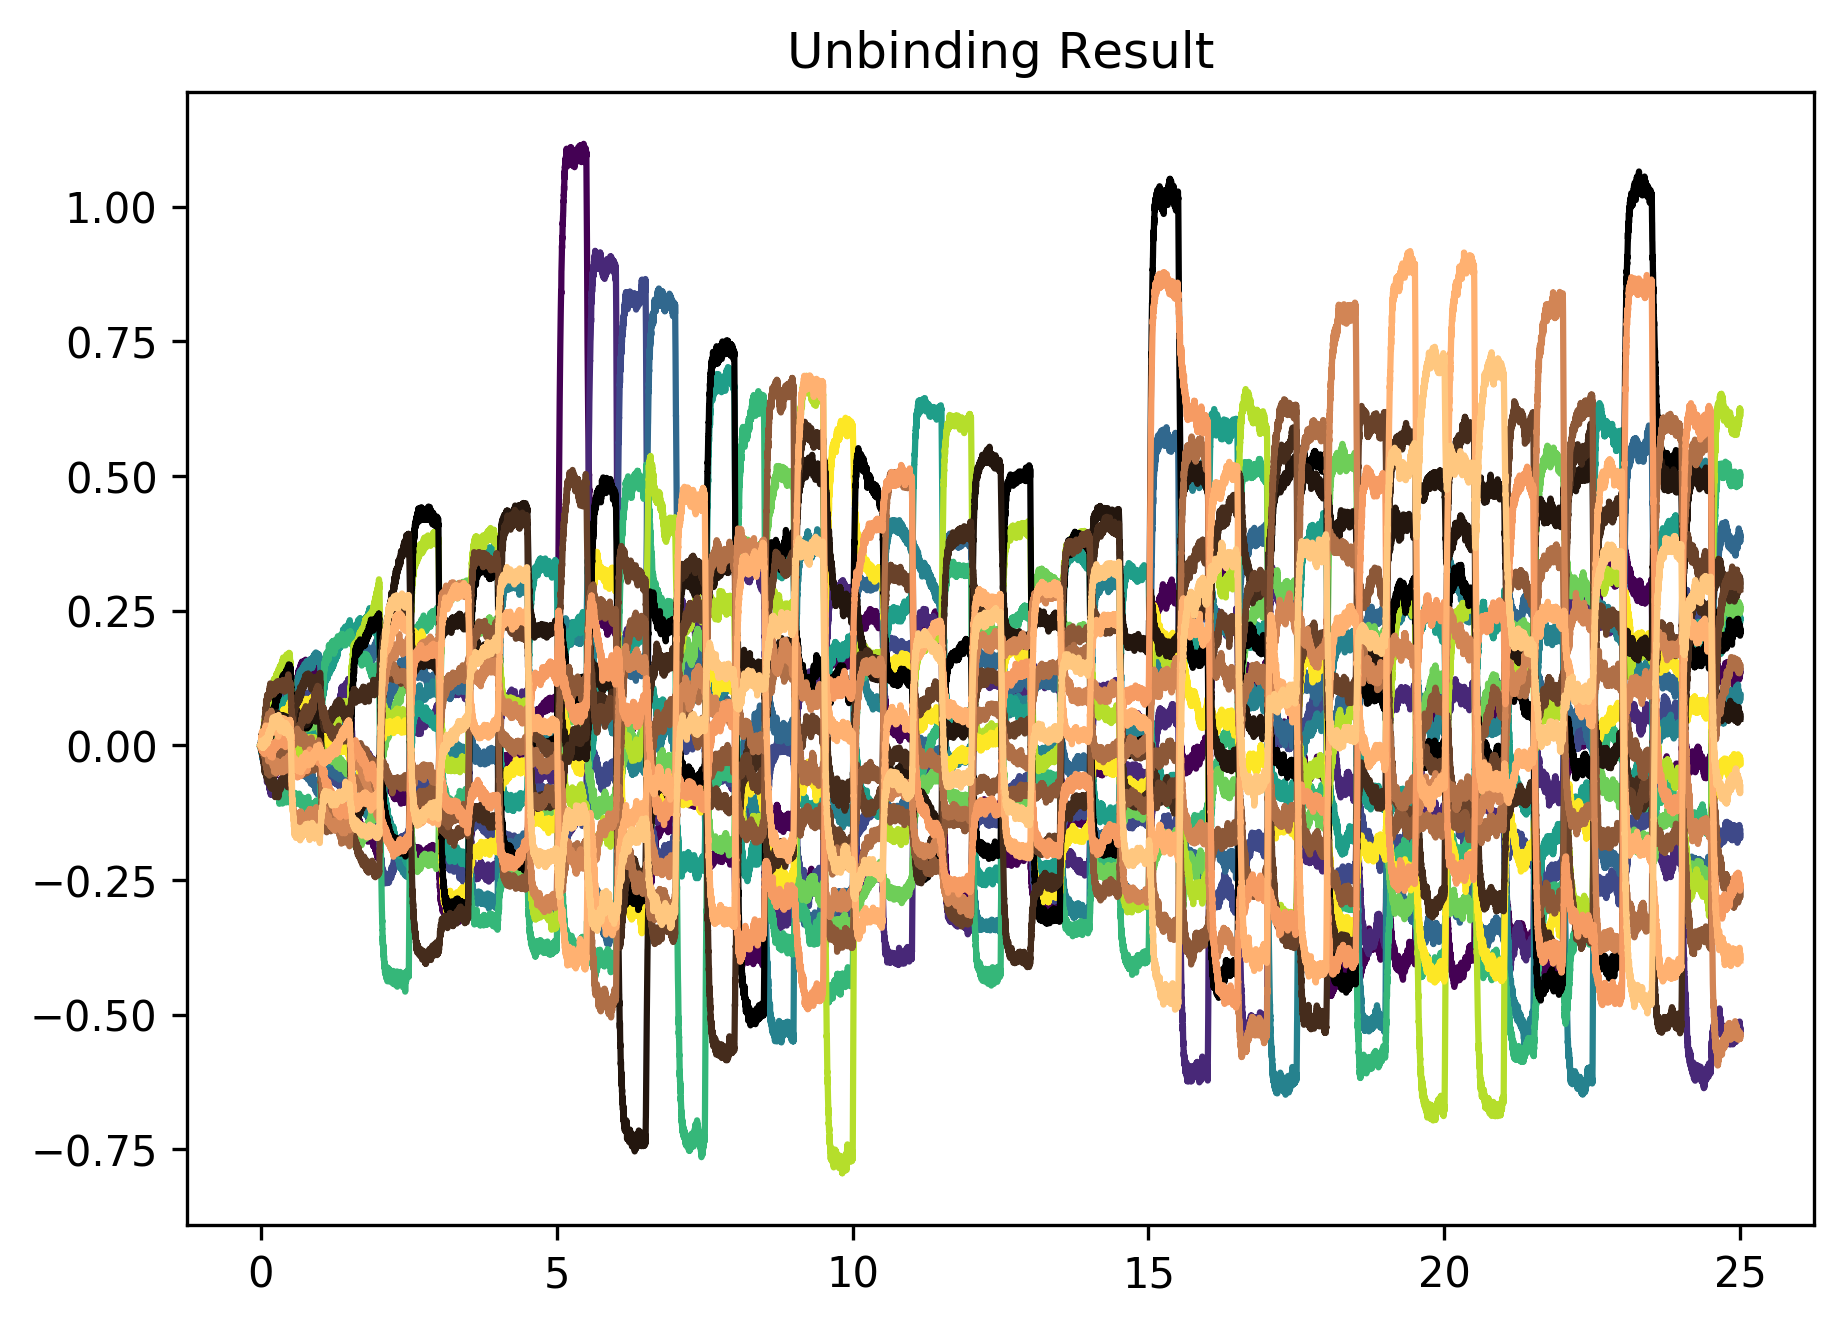

In [42]:
plt.figure(figsize=[7,5],dpi=300)
plt.title("Unbinding Result")
plt.plot(sim.trange(), spa.similarity(sim.data[p_out], response))
plt.savefig('Images/Test4_result.png')

In [43]:
testAcc(p_out,response,valnames)

(12,
 4,
 [['B1', 'D4', 'B6'],
  ['B2', 'D1', 'B10'],
  ['B3', 'B7', 'D4'],
  ['B4', 'B9', 'B7'],
  ['D9', 'D3', 'D2'],
  ['D1', 'B6', 'D6'],
  ['B7', 'D7', 'B8'],
  ['D5', 'B8', 'D1'],
  ['D9', 'B9', 'D3'],
  ['B10', 'B2', 'D2'],
  ['D1', 'D8', 'B4'],
  ['D8', 'D6', 'B5'],
  ['B6', 'D9', 'D3'],
  ['B9', 'B7', 'B4'],
  ['D5', 'D3', 'D2'],
  ['D6', 'D1', 'D2'],
  ['D7', 'B8', 'D2'],
  ['D4', 'D8', 'D5'],
  ['D9', 'D3', 'D10'],
  ['D10', 'D2', 'D8'],
  ['D9', 'D3', 'D10'],
  ['D10', 'D2', 'D8'],
  ['D4', 'D8', 'D5'],
  ['D7', 'B8', 'D2'],
  ['D5', 'D3', 'D2'],
  ['B6', 'D9', 'D3'],
  ['D1', 'D8', 'B4'],
  ['D6', 'D1', 'D2'],
  ['D8', 'D6', 'B5'],
  ['B9', 'B7', 'B4']])

In [32]:
cues

['A9', 'A10', 'A8', 'A7', 'A5', 'A3', 'A1', 'A6', 'A2', 'A4']